In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataloader import *

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

# Setting random seed for consistent behavior
import random
train_seed = 72 - 3
random.seed(train_seed)
torch.manual_seed(train_seed)
torch.cuda.manual_seed(train_seed)
torch.backends.cudnn.deterministic = True
random.seed(train_seed)
np.random.seed(train_seed)

# Environment & Data Configuration

In [2]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 9
#batch_size = 16        # Note: in og CML trajectory length == batch_size; in POCML this should be decoupled
n_obs = 9
trajectory_length = 12  # numer of node visits in a trajectory
num_desired_trajectories= 20

# choose env from "random", "small world" or "dead ends"
# TODO devouple batch_size from trajectory length for GraphEnv
# env = GraphEnv(n_nodes=n_nodes, n_items=n_obs, env='regular', action_type = "regular", batch_size=trajectory_length, num_desired_trajectories=num_desired_trajectories, unique = True)

env = GraphEnv( n_items=n_nodes,                     # number of possible observations
                env='grid', 
                batch_size=trajectory_length, 
                num_desired_trajectories=num_desired_trajectories, 
                device=None, 
                unique=True,                         # each state is assigned a unique observation if true
                args = {"rows": 3, "cols": 3}
            )
# env = GraphEnv( n_items=n_nodes,                     # number of possible observations
#                 env='two tunnel', 
#                 batch_size=trajectory_length, 
#                 num_desired_trajectories=num_desired_trajectories, 
#                 device=None, 
#                 unique=True,                         # each state is assigned a unique observation if true
#                 args = {"tunnel_length": 1, "middle_tunnel_length": 1}
#             )

#dataset = RandomWalkDataset(env.adj_matrix, trajectory_length, num_desired_trajectories, n_obs, env.items)
train_dataset = env.gen_dataset()
test_dataset = env.gen_dataset()

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

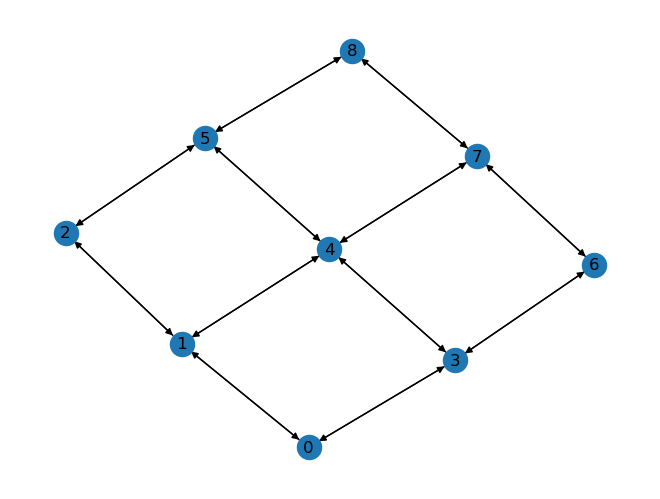

number of actions: 4
Sample trajectory:
tensor([[[6, 3, 7],
         [7, 2, 6],
         [6, 0, 3],
         [3, 1, 6],
         [6, 0, 3],
         [3, 0, 0],
         [0, 1, 3],
         [3, 1, 6],
         [6, 0, 3],
         [3, 3, 4],
         [4, 3, 5]]])
S-O mapping:
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
action-to-node:
{1: tensor([5, 8]), 3: tensor([7, 8]), 2: tensor([8, 7]), 0: tensor([8, 5])}
node-to-action-matrix:
tensor([[-1,  3, -1,  1, -1, -1, -1, -1, -1],
        [ 2, -1,  3, -1,  1, -1, -1, -1, -1],
        [-1,  2, -1, -1, -1,  1, -1, -1, -1],
        [ 0, -1, -1, -1,  3, -1,  1, -1, -1],
        [-1,  0, -1,  2, -1,  3, -1,  1, -1],
        [-1, -1,  0, -1,  2, -1, -1, -1,  1],
        [-1, -1, -1,  0, -1, -1, -1,  3, -1],
        [-1, -1, -1, -1,  0, -1,  2, -1,  3],
        [-1, -1, -1, -1, -1,  0, -1,  2, -1]])
affordance / node - to action:
{0: tensor([1, 3]), 1: tensor([1, 2, 3]), 2: tensor([1, 2]), 3: tensor([0, 1, 3]), 4: tensor([0, 1, 2, 3]), 5: tensor([0, 1, 2]

In [3]:
adj = env.adj_matrix

# Assuming you have the adjacency matrix stored in the variable "adj"
G = nx.from_numpy_array(adj.numpy().astype(float), create_using = nx.DiGraph)

# Draw the graph using seaborn
# sns.set()
seed = 68 # Consistent graph shape across runs
pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos = pos, with_labels=True)
# Show the plot
plt.show()

print(f"number of actions: {env.n_actions}")

print("Sample trajectory:")
for trajectory in train_dataloader:
    print(trajectory)
    break

print("S-O mapping:")
print(env.items)
print("action-to-node:")
print(env.action_to_node)
print("node-to-action-matrix:")
print(env.node_to_action_matrix)
print("affordance / node - to action:")
print(env.affordance)

# Model & Trainer Config 

In [90]:
# Our code
from trainer import POCMLTrainer
from model import POCML, sim

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = 20
random_feature_dim = 1000
epochs = 400

model = POCML(
    n_obs = env.n_items,
    n_states = env.size,
    n_actions = env.n_actions,
    state_dim = state_dim,
    random_feature_dim = random_feature_dim,
    alpha = 2,
    memory_bypass=True,
)
    
trainer = POCMLTrainer(
    model=model, 
    train_loader = train_dataloader,
    lr_Q = 0.1, 
    lr_V = 0.08, 
    lr_all = 0.005,
    normalize = False,
    reset_every=5, # never reset,
    update_state_given_obs=True,
    debug=False
)

loss_record, best_model = trainer.train(epochs)
model = best_model

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

In [85]:
print("State differences:\n", model.get_state_differences())
print("Action similarities:\n", model.get_action_similarities())

State differences:
 tensor([[  0.0000,  46.7349,  94.7741,  54.0428,  63.5468,  98.3685, 104.0522,
         103.8359, 122.8991],
        [ 46.7349,   0.0000,  48.6952,  75.3895,  49.7819,  61.7999, 117.3700,
          97.9669,  97.7952],
        [ 94.7741,  48.6952,   0.0000, 116.9038,  77.5789,  53.0090, 150.2916,
         118.8573,  97.0002],
        [ 54.0428,  75.3895, 116.9038,   0.0000,  46.5358,  92.9955,  50.2075,
          60.8460,  96.5755],
        [ 63.5468,  49.7819,  77.5789,  46.5358,   0.0000,  46.8241,  72.9966,
          48.4097,  59.7529],
        [ 98.3685,  61.7999,  53.0090,  92.9955,  46.8241,   0.0000, 111.0125,
          72.2022,  44.1269],
        [104.0522, 117.3700, 150.2916,  50.2075,  72.9966, 111.0125,   0.0000,
          44.8475,  92.6822],
        [103.8359,  97.9669, 118.8573,  60.8460,  48.4097,  72.2022,  44.8475,
           0.0000,  48.2191],
        [122.8991,  97.7952,  97.0002,  96.5755,  59.7529,  44.1269,  92.6822,
          48.2191,   0.0000]]

In [45]:
phi_Q = model.get_state_kernel()
phi_V = model.get_action_kernel()
print("State kernel similarities:\n", sim(phi_Q, phi_Q))
print("Action kernel similarities:\n", sim(phi_V, phi_V))

State kernel similarities:
 tensor([[1.0000e+00, 1.0000e-06, 1.0000e-06, 2.2319e-02, 1.0000e-06, 5.0316e-03,
         1.0000e-06, 1.0000e-06, 7.0464e-03],
        [1.0000e-06, 1.0000e+00, 1.0000e-06, 1.0000e-06, 1.1951e-02, 9.3922e-03,
         8.6170e-03, 1.0000e-06, 8.9924e-03],
        [1.0000e-06, 1.0000e-06, 1.0000e+00, 1.0000e-06, 1.0000e-06, 2.5961e-02,
         1.0000e-06, 1.0000e-06, 1.0000e-06],
        [2.2319e-02, 1.0000e-06, 1.0000e-06, 1.0000e+00, 1.0000e-06, 1.0000e-06,
         3.5029e-03, 1.0000e-06, 1.1710e-02],
        [1.0000e-06, 1.1951e-02, 1.0000e-06, 1.0000e-06, 1.0000e+00, 2.5969e-03,
         1.0000e-06, 3.3749e-03, 2.3594e-03],
        [5.0316e-03, 9.3922e-03, 2.5961e-02, 1.0000e-06, 2.5969e-03, 1.0000e+00,
         1.0000e-06, 5.4156e-03, 1.1199e-02],
        [1.0000e-06, 8.6170e-03, 1.0000e-06, 3.5029e-03, 1.0000e-06, 1.0000e-06,
         1.0000e+00, 1.0000e-06, 1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 3.3749e-03, 5.4156e-03,
  

In [83]:
# beta_obs, beta_state, clean up rate
torch.save(model.state_dict(), "model/model.ckpt")

In [91]:
import evaluate

train_acc, train_confidences = evaluate.accuracy(model, train_dataloader)
print("Train obs accuracy/confidence:", train_acc, np.mean(train_confidences))

test_acc, test_confidences = evaluate.accuracy(model, test_dataloader)
print("Test obs accuracy/confidence:", test_acc, np.mean(test_confidences))

sa_acc, sa_confidences, sa_distance_ratios = evaluate.state_transition_consistency(model, env)
print("State-action accuracy/confidence/distance ratio:", sa_acc, np.mean(sa_confidences), np.mean(sa_distance_ratios))

Train obs accuracy/confidence: 1.0 0.8627259276129983
Test obs accuracy/confidence: 1.0 0.852331536195495
State-action accuracy/confidence/distance ratio: 1.0 0.8536107788483301 0.2996817247905011


In [67]:
from sklearn.manifold import MDS

def visualize(distances, legend:str ="Node"):
    mds = MDS(n_components =2)
    positions = mds.fit_transform(distances)

    plt.figure(figsize=(8, 6))
    plt.scatter(positions[:, 0], positions[:, 1])

    # Optional: Annotate the points
    for i, (x, y) in enumerate(positions):
        plt.text(x, y, f'{legend} {i}', fontsize=12)

    plt.title('Graph Visualization using MDS')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()

/Users/calvin/miniforge3/envs/pytorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


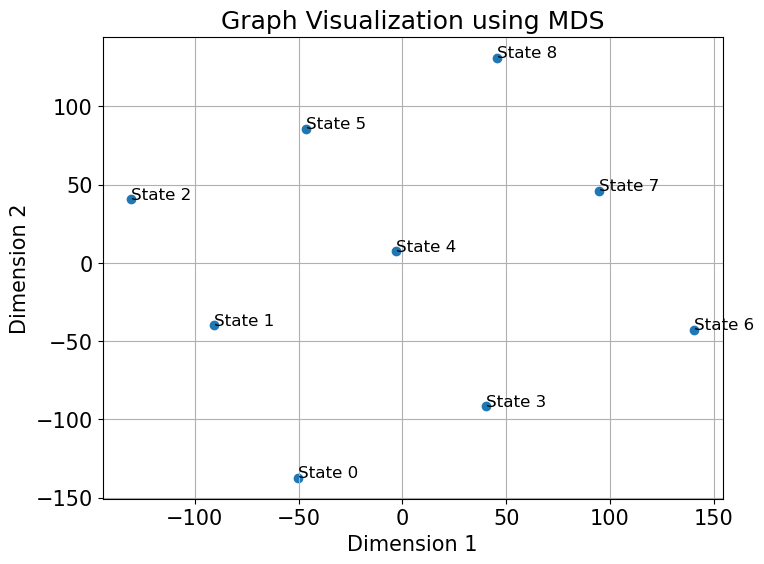

In [81]:
visualize(model.get_state_differences().numpy(), legend = "State")

/Users/calvin/miniforge3/envs/pytorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


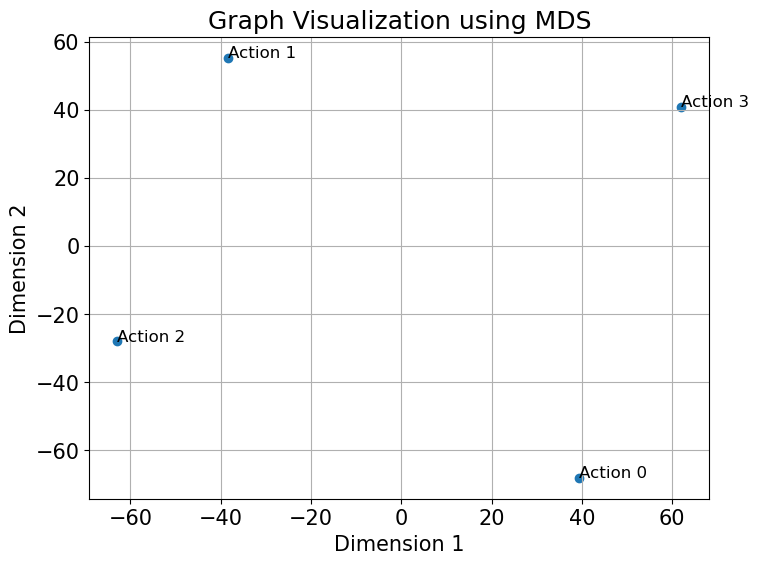

In [82]:
visualize(model.get_action_differences().numpy(), "Action")

Text(0.5, 0, 'Epochs')

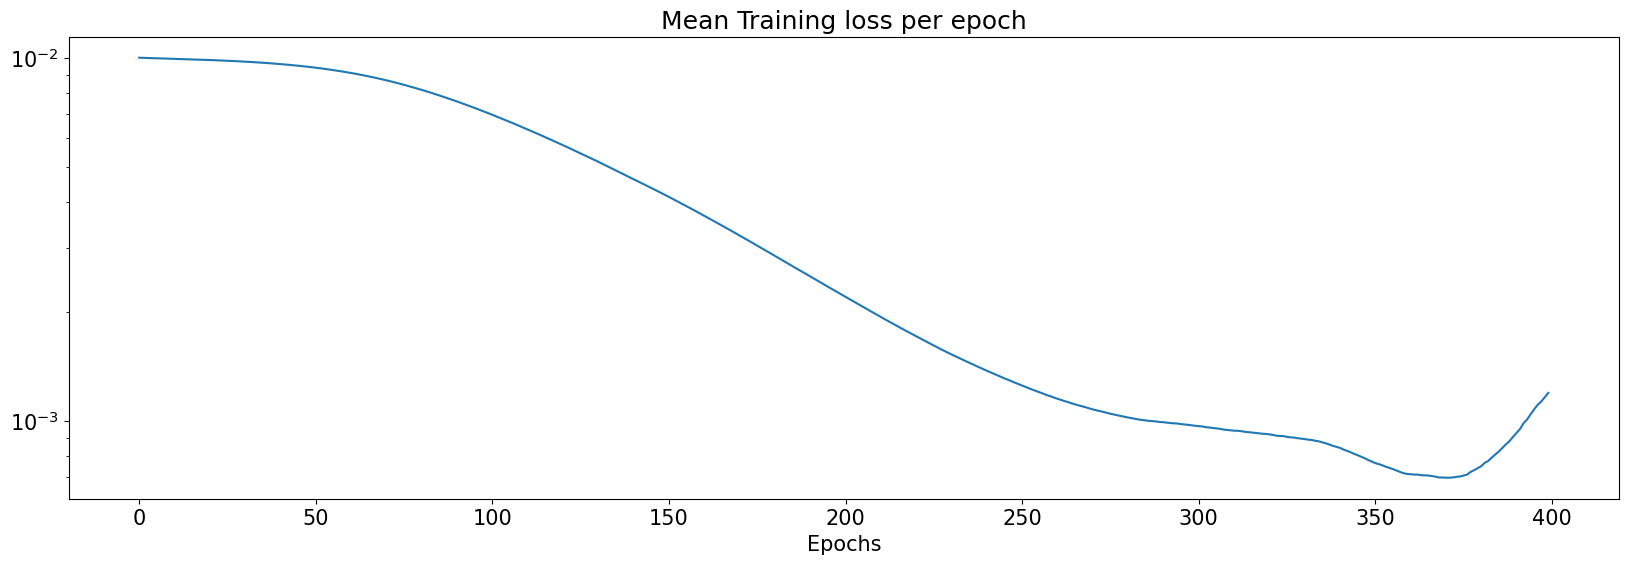

In [92]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(np.mean(loss_record, axis=1)/(env.num_desired_trajectories * (env.batch_size-1) ))
plt.yscale('log')
plt.title('Mean Training loss per epoch') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


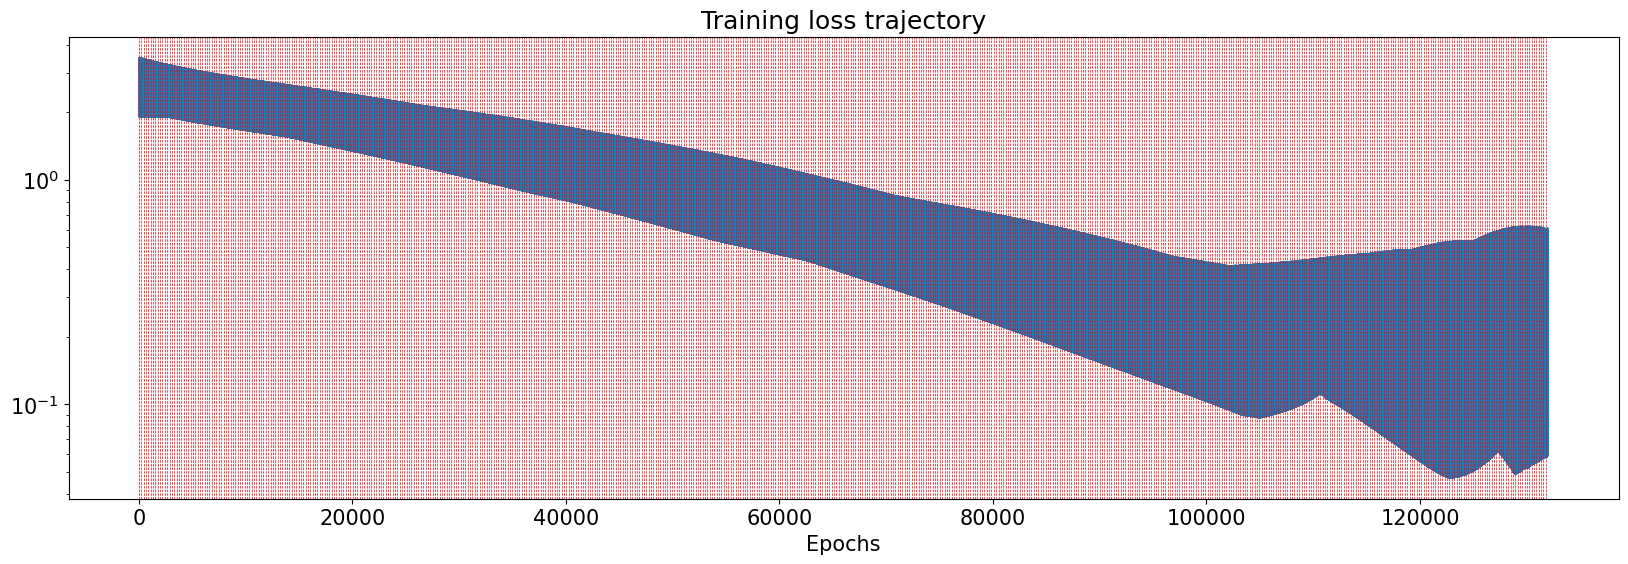

In [76]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(loss_record.reshape(-1))
plt.yscale('log')
plt.title('Training loss trajectory') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

# Get the current y-ticks
yticks = plt.yticks()[0]

print(yticks)

# Add vertical lines at each multiple of 5

for i in range(0, len(loss_record.reshape(-1)), num_desired_trajectories * (trajectory_length-1)):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.5)



In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            #steps, o_record = model.plan(start_idx, goal_idx, env, False)
            steps = model.plan(state, affordance=None):

        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:
# CML's model

def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_matrix(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 